# Transformer


In this notebook I will train a Transformer model preconfigured from huggingface.The dataset is Beijing air quality, from UCI machine learning repository.

In [202]:
# importing libraries

from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction
from huggingface_hub import hf_hub_download
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import os

In [188]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)

Using device: cpu


In [203]:
os.environ['PYTHONHASHSEED'] = str(42)

# reading csv file and dropping missing values


In [195]:
# file = pd.read_csv("./guanyuan.csv")
file = pd.read_csv("./wanliu.csv")
file = file.dropna()

# data preparation
date = (file["day"].astype(str) + "/" + file["month"].astype(str) + "/" + file["year"].astype(str) + "," + file["hour"].astype(str))
pm = file["PM2.5"]

df = pd.DataFrame({"date": date, "PM2.5": pm})
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y,%H')
df.set_index('date', inplace=True)

# Resample data to an hourly frequency
df = df.resample('H').mean().interpolate(method='linear')

# Extract hour, day of week, and month
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['year'] = df.index.year

df['realhour'] = df['hour']
df['realdayofweek'] = df['dayofweek']
df['realmonth'] = df['month']


df['hour'] = np.sin(df['hour'] * (2. * np.pi / 24))
df['dayofweek'] = np.sin(df['dayofweek'] * (2. * np.pi / 7))
df['month'] = np.sin(df['month'] * (2. * np.pi / 12))
df['year'] = df['year'] - 2013

df = df[25064:]

df.head()




,PM2.5,hour,dayofweek,month,year,realhour,realdayofweek,realmonth
date,,,,,,,,
2016-01-09 08:00:00,38.0,8.660254e-01,-0.974928,0.5,3,8,5,1
2016-01-09 09:00:00,35.0,7.071068e-01,-0.974928,0.5,3,9,5,1
2016-01-09 10:00:00,35.0,5.000000e-01,-0.974928,0.5,3,10,5,1
2016-01-09 11:00:00,33.0,2.588190e-01,-0.974928,0.5,3,11,5,1
2016-01-09 12:00:00,45.0,1.224647e-16,-0.974928,0.5,3,12,5,1


## Autocorrelation for lag sequence


/Users/danieluyterlinde/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


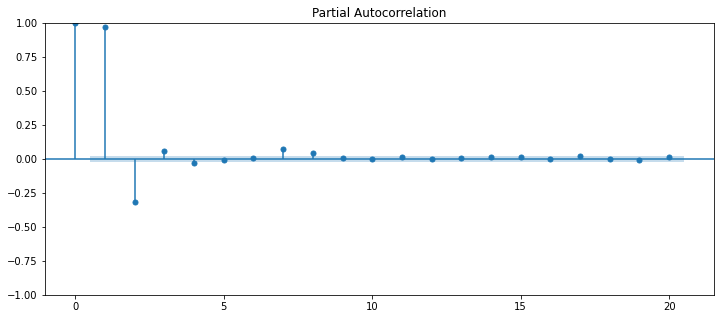

In [196]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

pm25 = df['PM2.5']

# Plot the PACF of PM2.5 to determine lag sequence
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(pm25, lags=20, ax=ax)
plt.show()

## Normalizing data from 0-1

In [197]:
# # Only fit scaler for the first column
# scalers = {}
# scalers[df.columns[0]] = MinMaxScaler().fit(df[df.columns[0]].values.reshape(-1, 1))

# # Transform data via scaler
# norm_df = df.copy()
# norm = scalers[df.columns[0]].transform(norm_df.iloc[:, 0].values.reshape(-1, 1))
# norm_df.iloc[:, 0] = norm

# df = norm_df
# torchdf = torch.tensor(df['PM2.5'].values).unsqueeze(1)

# splitting data into train & test sets
# train_size = int(len(df) * 0.8)
# train_data = df[:train_size]
# test_data = df[train_size:]

# train_data.head()


## Window / sequence generator

In [279]:

# def generate_sequences(df: pd.DataFrame, tw: int, pw: int, target_columns, drop_targets=False):
#   '''
#   df: Pandas DataFrame of the univariate time-series
#   tw: Training Window - Integer defining how many steps to look back
#   pw: Prediction Window - Integer defining how many steps forward to predict

#   returns: dictionary of sequences and targets for all sequences
#   '''
#   data = dict() # Store results into a dictionary
#   L = len(df)
#   for i in range(L-tw):
#     # Option to drop target from dataframe
#     if drop_targets:
#       df.drop(target_columns, axis=1, inplace=True)

#     # Get current sequence  
#     sequence = df[i:i+tw].values
#     # Get values right after the current sequence
#     target = df[i+tw:i+tw+pw][target_columns].values
    
#     # Check if sequence has correct length
#     if len(sequence) != tw:
#       raise ValueError(f"Sequence starting at index {i} has length {len(sequence)} instead of {tw}")

#     data[i] = {'sequence': sequence, 'target': target}
#   return data

# class SequenceDataset():

#     def __init__(self, df):
#         self.data = df

#     def __getitem__(self, idx):
#         sample = self.data[idx]
#         return torch.Tensor(sample['sequence']), torch.Tensor(sample['target'])
  
#     def __len__(self):
#         return len(self.data)


def generate_sequences(df: pd.DataFrame, tw: int, pw: int, target_columns, drop_targets=False):
    '''
    df: Pandas DataFrame of the univariate time-series
    tw: Training Window - Integer defining how many steps to look back
    pw: Prediction Window - Integer defining how many steps forward to predict

    returns: dictionary of sequences and targets for all sequences
    '''
    data = dict() # Store results into a dictionary
    L = len(df)
    for i in range(L-tw-pw+1):
        # Option to drop target from dataframe
        if drop_targets:
            df.drop(target_columns, axis=1, inplace=True)

        # Get current sequence  
        sequence = df[i:i+tw].values
        # Get values right after the current sequence
        target = df[i+tw:i+tw+pw][target_columns].values

        # Check if sequence has correct length
        if len(sequence) != tw:
            raise ValueError(f"Sequence starting at index {i} has length {len(sequence)} instead of {tw}")

        data[i] = {'sequence': sequence, 'target': target}

    return data

class SequenceDataset():

    def __init__(self, df, pw):
        self.data = df
        self.pw = pw

    def __getitem__(self, idx):
        sample = self.data[idx]
        return torch.Tensor(sample['sequence']), torch.Tensor(sample['target']).view(-1, self.pw)

    def __len__(self):
        return len(self.data)
    

# function to determine the next time features
def get_future_time_features(last_time_features):
    
    hour = last_time_features[:,:,4]
    dayofweek = last_time_features[:,:,5]
    month = last_time_features[:,:,6]
    year = last_time_features[:,:,3]
    
    newhour = hour + 1
    
    # if newhour is 24, set it to 0 and increment dayofweek
    newdayofweek = torch.where(newhour == 24, dayofweek + 1, dayofweek)
    newhour = torch.where(newhour == 24, torch.tensor(0, dtype=torch.float), newhour)
    
    # set dayofweek to 1 and increment month if newdayofweek is 8
    newmonth = torch.where(newdayofweek == 8, month + 1, month)
    newdayofweek = torch.where(newdayofweek == 8, torch.tensor(1, dtype=torch.float), newdayofweek)
    
    # increment year if newmonth is 13
    newyear = torch.where(newmonth == 13, year + 1, year)
    newmonth = torch.where(newmonth == 13, torch.tensor(1, dtype=torch.float), newmonth)
    
    newhour = np.sin(newhour * (2. * np.pi / 24))
    newdayofweek = np.sin(newdayofweek * (2. * np.pi / 7))
    newmonth = np.sin(newmonth * (2. * np.pi / 12))
    
    new_time_features = torch.stack([newhour, newdayofweek, newmonth], dim=-1)
    
    return new_time_features



In [281]:

# Here we are defining properties for our model
sequence_len = 73

BATCH_SIZE = 64 # Training batch size
split = 0.8 # Train/Test Split ratio

sequences = generate_sequences(df, sequence_len, 3, 'PM2.5')
dataset = SequenceDataset(sequences, 3)

# Split the data into train, validation, and test sets
train_len = int(len(dataset)*split)
val_len = (len(dataset) - train_len) // 2
test_len = len(dataset) - train_len - val_len
train_ds, val_ds, test_ds = random_split(dataset, [train_len, val_len, test_len])

torch.manual_seed(42)  # set a seed for reproducibility
np.random.seed(42)

def worker_init_fn(worker_id):
    np.random.seed(42 + worker_id)

# Load each subset into a separate DataLoader object
trainloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valloader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
testloader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)


In [291]:

for x,y in trainloader:
    past_values = x[:, :, 0]
    past_time_features = x[:, :, 1:4]
    future_values = y
    last_time_features= x[:,-3:,1:]
#     print(last_time_features)[0]
    future_time_features = get_future_time_features(last_time_features)
#     print(future_time_features[0])
    break
    

Epoch 1
training loss:  5.5269
validation loss:  5.3985
Epoch 2
training loss:  5.1321
validation loss:  4.6816
Epoch 3
training loss:  4.5003
validation loss:  4.3528
Epoch 4
training loss:  4.2786
validation loss:  4.2006
Epoch 5
training loss:  4.1647
validation loss:  4.1217
Epoch 6
training loss:  4.0966
validation loss:  4.0719
Epoch 7
training loss:  4.0439
validation loss:  4.0411
Epoch 8
training loss:  4.0037
validation loss:  3.9959
Epoch 9
training loss:  3.9725
validation loss:  4.0234
Epoch 10
training loss:  3.9462
validation loss:  3.9580
Epoch 11
training loss:  3.9302
validation loss:  3.9250
Epoch 12
training loss:  3.9218
validation loss:  4.0548
Epoch 13
training loss:  3.9114
validation loss:  3.9031
Epoch 14
training loss:  3.9075
validation loss:  3.9517
Epoch 15
training loss:  3.8929
validation loss:  3.8917
Epoch 16
training loss:  3.8825
validation loss:  3.8811
Epoch 17
training loss:  3.8759
validation loss:  3.8777
Epoch 18
training loss:  3.8826
validati

training loss:  3.5981
validation loss:  3.6747
Epoch 145
training loss:  3.5925
validation loss:  3.6747
Epoch 146
training loss:  3.5915
validation loss:  3.6654
Early stopping at epoch 145


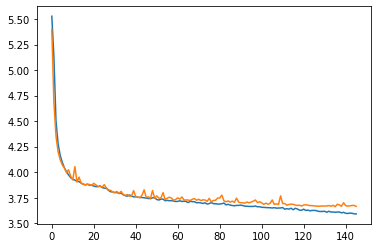

In [297]:
from transformers import TimeSeriesTransformerForPrediction
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerModel
from transformers import AdamW

val_losses = []
train_losses = []
counter = 0
max_epochs = 200
best_val_loss = float('inf')
patience = 0

# Initializing a Time Series Transformer configuration with 1 time steps for prediction
configuration = TimeSeriesTransformerConfig(prediction_length=3,  
                                            num_time_features=3, 
                                            lags_sequence=[1,2], 
                                            input_size=1, 
                                            context_length=71,
                                            encoder_layers=4,
                                            decoder_layers=4,
                                            dropout=0.2,
                                            attention_dropout=0.2,
                                            activation_dropout=0.2)

model = TimeSeriesTransformerForPrediction(configuration)
configuration = model.config
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for epoch in range(max_epochs):
    
    counter += 1
    print('Epoch', counter)
    
    mean_loss = []
    
    for x,y in trainloader:
        # during training, one provides both past and future values
        # as well as possible additional features
        past_values = x[:, :, 0]
        past_time_features = x[:,:,1:4]
        last_time_features = x[:,-3:,1:]
        future_values = y.squeeze()
        future_time_features = get_future_time_features(last_time_features)
        
        outputs = model(
            past_values=x[:, :, 0],                    # shape: (batch_size, sequence_length)
            past_time_features=x[:, :, 1:4],            # shape: (batch_size, sequence_length, num_features)
            past_observed_mask=None,
            static_categorical_features=None,
            static_real_features=None,
            future_values=future_values,                           # shape: (batch_size, prediction_length)
            future_time_features=future_time_features, # shape: (batch_size, prediction_length, num_features)
        )

        loss = outputs.loss
        
        mean_loss.append(loss.item())
        
        loss.backward()
        optimizer.step() # update parameters
        optimizer.zero_grad() # reset gradients
        
    avg_loss = sum(mean_loss) / len(mean_loss)
    
    train_losses.append(avg_loss)
    print('training loss: ', "{:.4f}".format(avg_loss))
    
    mean_loss = []
    
    model.eval()
    with torch.no_grad():
        for x, y in valloader:
            past_values = x[:, :, 0]
            past_time_features = x[:,:,1:4]
            last_time_features = x[:,-3:,1:]
            future_values = y.squeeze()
            future_time_features = get_future_time_features(last_time_features)
            
            outputs = model(
                past_values=past_values,
                past_time_features=past_time_features,
                past_observed_mask=None,
                static_categorical_features=None,
                static_real_features=None,
                future_values=future_values,
                future_time_features=future_time_features,
            )

            loss = outputs.loss
            mean_loss.append(loss.item())
            
    avg_loss = sum(mean_loss) / len(mean_loss)
    val_losses.append(avg_loss)
    print('validation loss: ', "{:.4f}".format(avg_loss))
    
    # Early stopping with patience of 5 and restoring the best weights
    if avg_loss < best_val_loss:
        best_val_loss = avg_loss
        patience = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        patience += 1
        if patience >= 10:
            print('Early stopping at epoch', epoch)
            break
        else:
            continue

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

# # during inference, one only provides past values
# # as well as possible additional features
# # the model autoregressively generates future values
# outputs = model.generate(
#     past_values=past_values,
#     past_time_features=past_time_features,
#     past_observed_mask=None,
#     static_categorical_features=None,
#     static_real_features=None,
#     future_time_features=future_time_features,
# )

# mean_prediction = outputs.sequences.mean(dim=1)
# print(mean_prediction)

In [299]:
configuration = TimeSeriesTransformerConfig(prediction_length=3,  
                                            num_time_features=3, 
                                            lags_sequence=[1,2], 
                                            input_size=1, 
                                            context_length=71,
                                            encoder_layers=4,
                                            decoder_layers=4,
                                            dropout=0.2,
                                            attention_dropout=0.2,
                                            activation_dropout=0.2)


model = TimeSeriesTransformerForPrediction(configuration)

model.load_state_dict(torch.load('best_model.pt'))


print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's state_dict:
model.encoder.value_embedding.value_projection.weight 	 torch.Size([64, 7])
model.encoder.embed_positions.weight 	 torch.Size([74, 64])
model.encoder.layers.0.self_attn.k_proj.weight 	 torch.Size([64, 64])
model.encoder.layers.0.self_attn.k_proj.bias 	 torch.Size([64])
model.encoder.layers.0.self_attn.v_proj.weight 	 torch.Size([64, 64])
model.encoder.layers.0.self_attn.v_proj.bias 	 torch.Size([64])
model.encoder.layers.0.self_attn.q_proj.weight 	 torch.Size([64, 64])
model.encoder.layers.0.self_attn.q_proj.bias 	 torch.Size([64])
model.encoder.layers.0.self_attn.out_proj.weight 	 torch.Size([64, 64])
model.encoder.layers.0.self_attn.out_proj.bias 	 torch.Size([64])
model.encoder.layers.0.self_attn_layer_norm.weight 	 torch.Size([64])
model.encoder.layers.0.self_attn_layer_norm.bias 	 torch.Size([64])
model.encoder.layers.0.fc1.weight 	 torch.Size([32, 64])
model.encoder.layers.0.fc1.bias 	 torch.Size([32])
model.encoder.layers.0.fc2.weight 	 torch.Size([64, 32])
m

In [393]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def evaluate_model_rmse(model, dataloader):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for x, y in dataloader:
            past_values = x[:, :, 0]
            past_time_features = x[:, :, 1:4]
            future_values = y.squeeze()
            last_time_features = x[:,-3:,1:]
            future_time_features = get_future_time_features(last_time_features)


            outputs = model.generate(
                past_values=past_values,
                past_time_features=past_time_features,
                past_observed_mask=None,
                static_categorical_features=None,
                static_real_features=None,
                future_time_features=future_time_features
            )
            
            mean_prediction = outputs.sequences.mean(dim=1)
            
            predictions.append(mean_prediction)
            targets.append(future_values)
            

    predictions = torch.cat(predictions)
    targets = torch.cat(targets)
    mse = mean_squared_error(targets, predictions, multioutput='raw_values')
    rmse = np.sqrt(mse.mean())
    return rmse


from scipy.stats import pearsonr

def evaluate_model_pearson(model, dataloader):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for x, y in testloader:
            past_values = x[:, :, 0]
            past_time_features = x[:, :, 1:4]
            future_values = y.squeeze()
            last_time_features = x[:,-3:,1:]
            future_time_features = get_future_time_features(last_time_features)


            outputs = model.generate(
                past_values=past_values,
                past_time_features=past_time_features,
                past_observed_mask=None,
                static_categorical_features=None,
                static_real_features=None,
                future_time_features=future_time_features,
            )
            
            mean_prediction = outputs.sequences.mean(dim=1)
            
            predictions.append(mean_prediction)
            targets.append(y)
            

    predictions = torch.cat(predictions)
    targets = torch.cat(targets)
    corr, _ = pearsonr(targets.numpy().ravel(), predictions.numpy().ravel())
    
    return abs(corr)


## Transformer score


In [395]:
rmse = evaluate_model_rmse(model, testloader)
print('RMSE:', rmse)

pearson = evaluate_model_pearson(model, testloader)
print("Pearson correlation: ", "{:.4f}".format(pearson))

RMSE: 36.26408
Pearson correlation:  0.8831


## Baseline score


This baseline score predicts the values of the same time one day earlier.


In [403]:
def prev_day_baseline(testloader):
    predictions = []
    targets = []
    for x, y in testloader:
        targets.append(y.squeeze())
        
        prediction = x[:, -24:-21, 0]
        predictions.append(prediction)
    
    predictions = torch.cat(predictions)
    targets = torch.cat(targets)
    mse = mean_squared_error(targets, predictions, multioutput='raw_values')
    rmse = np.sqrt(mse.mean())

    return rmse

def prev_day_baseline_pearson(testloader):
    predictions = []
    targets = []
    for x, y in testloader:
        targets.append(y.squeeze())
        
        prediction = x[:, -24:-21, 0]
        predictions.append(prediction)
    
    predictions = torch.cat(predictions)
    targets = torch.cat(targets)
    corr, _ = pearsonr(targets.numpy().ravel(), predictions.numpy().ravel())

    return abs(corr)


rmse = prev_day_baseline(testloader)
print('RMSE:', rmse)

pearson_baseline = prev_day_baseline_pearson(testloader)
print("Pearson correlation: ", "{:.4f}".format(pearson_baseline))

RMSE: 84.918045
Pearson correlation:  0.4099


This baseline model predicts the last known value three times.

In [402]:
def last_value_baseline(testloader):
    predictions = []
    targets = []
    for x, y in testloader:
        # append only the last value of the sequence 3 times
        last_value = x[:, -1, 0].unsqueeze(-1)
        prediction = torch.cat([last_value]*3, dim=1)
        predictions.append(prediction)
        # append the true y values
        targets.append(y.squeeze())
    
    # concatenate the predictions and targets along the batch dimension
    predictions = torch.cat(predictions, dim=0)
    targets = torch.cat(targets, dim=0)
    
    mse = mean_squared_error(targets, predictions)
    rmse = np.sqrt(mse)
    
    return rmse

def last_value_baseline_pearson(testloader):
    predictions = []
    targets = []
    for x, y in testloader:
        # append only the last value of the sequence 3 times
        last_value = x[:, -1, 0].unsqueeze(-1)
        prediction = torch.cat([last_value]*3, dim=1)
        predictions.append(prediction)
        # append the true y values
        targets.append(y.squeeze())
    
    # concatenate the predictions and targets along the batch dimension
    predictions = torch.cat(predictions, dim=0)
    targets = torch.cat(targets, dim=0)
    
    corr, _ = pearsonr(targets.numpy().ravel(), predictions.numpy().ravel())
    
    return corr

rmse = last_value_baseline(testloader)
print('RMSE:', rmse)

pearson_baseline = last_value_baseline_pearson(testloader)
print("Pearson correlation: ", "{:.4f}".format(pearson_baseline))

RMSE: 27.411283
Pearson correlation:  0.9398


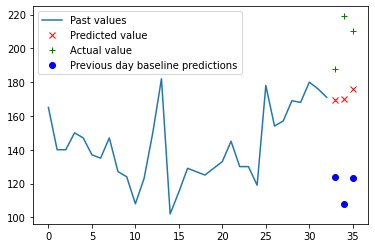

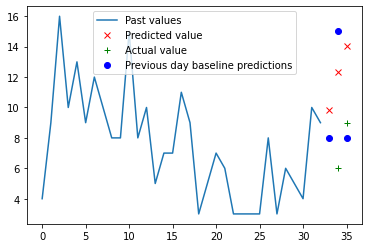

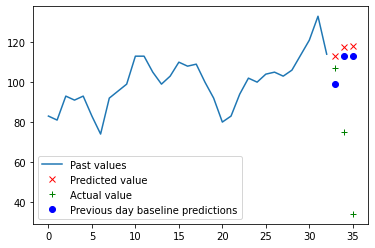

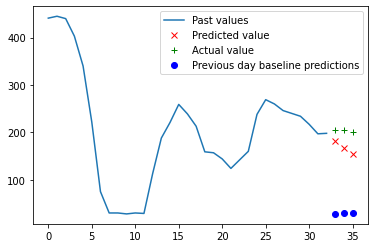

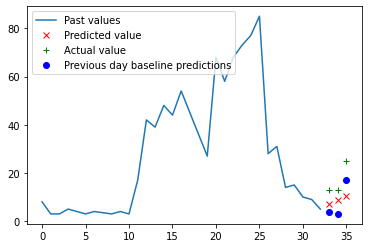

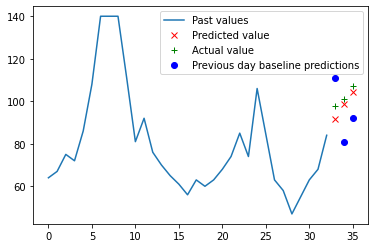

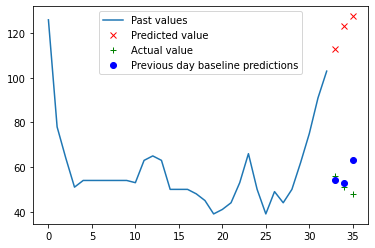

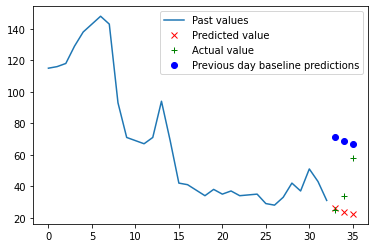

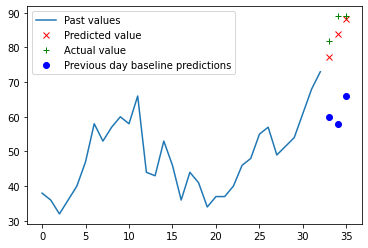

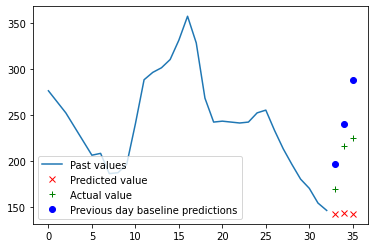

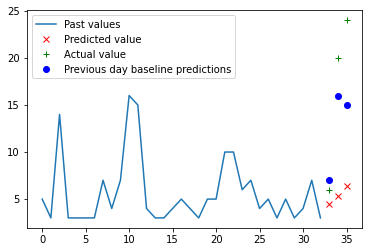

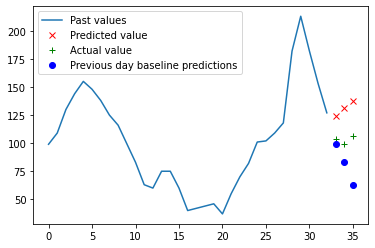

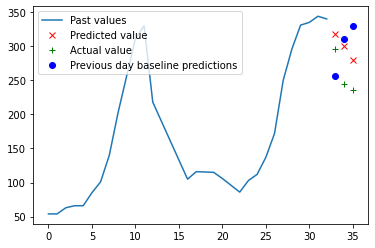

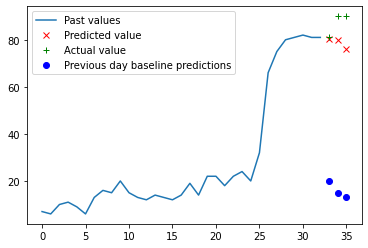

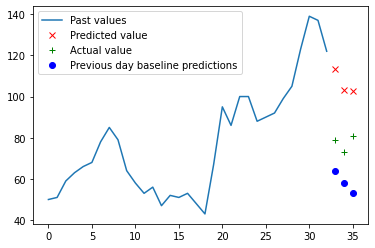

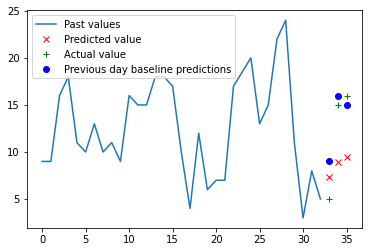

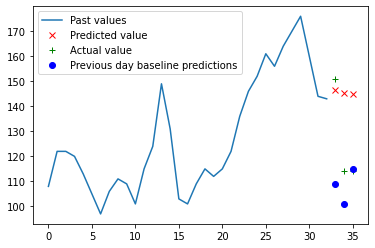

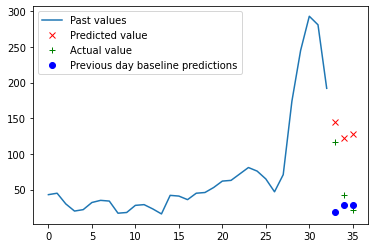

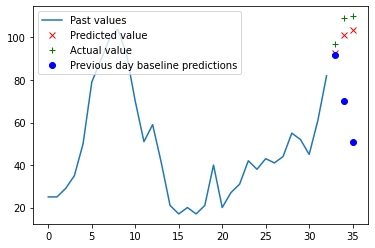

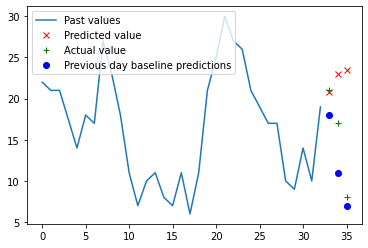

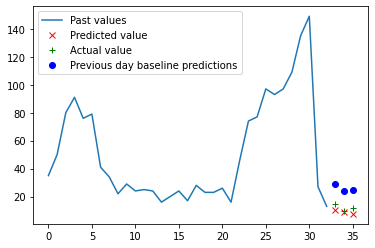

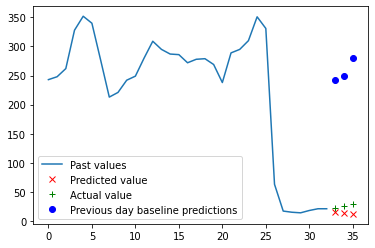

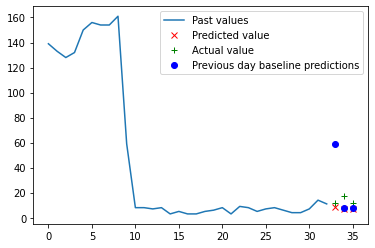

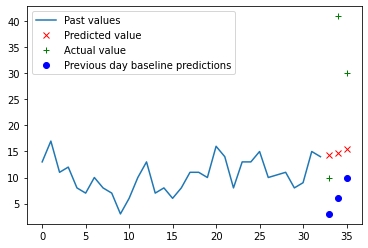

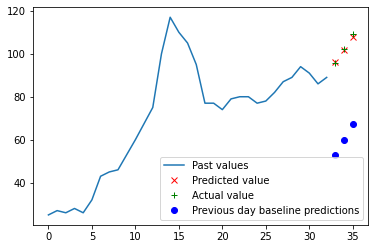

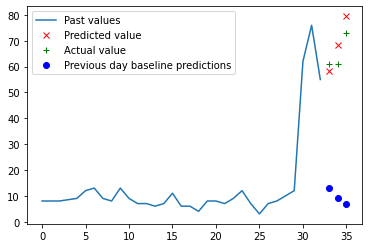

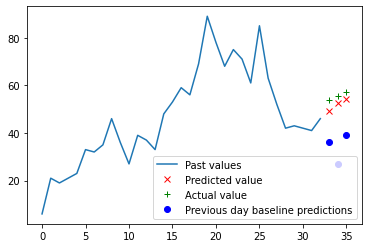

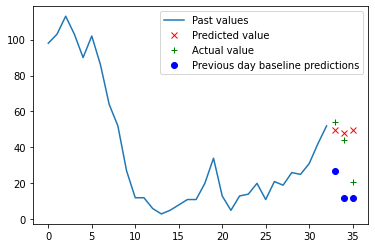

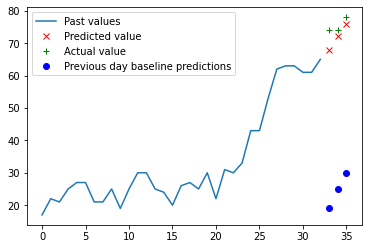

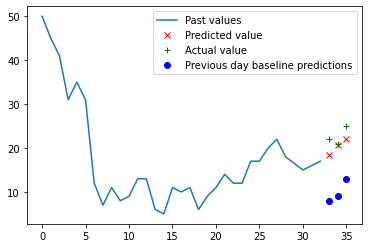

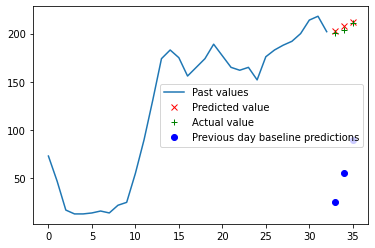

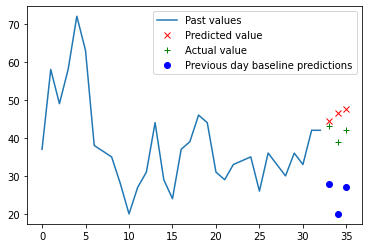

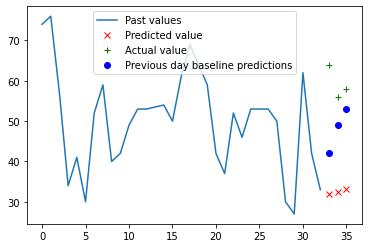

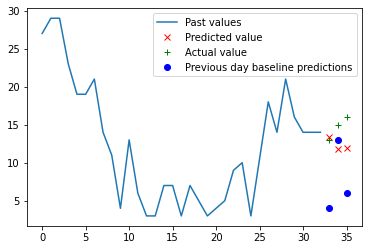

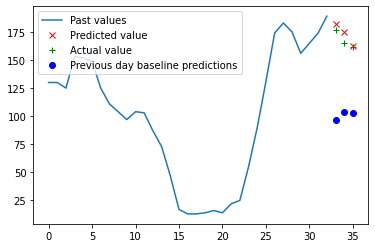

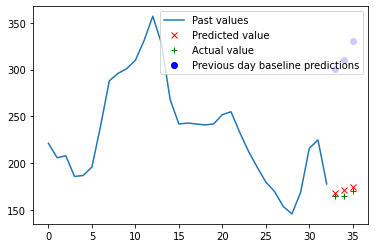

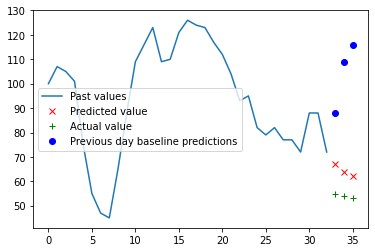

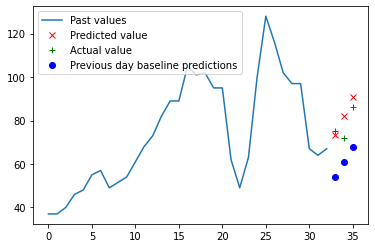

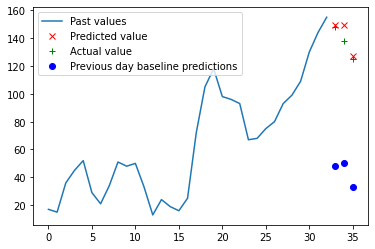

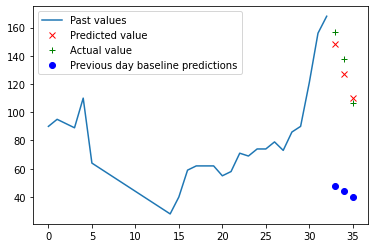

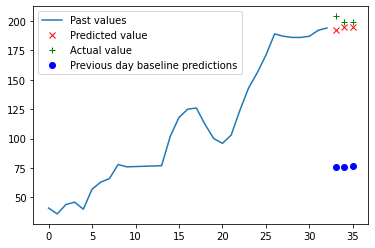

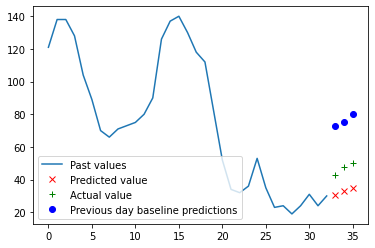

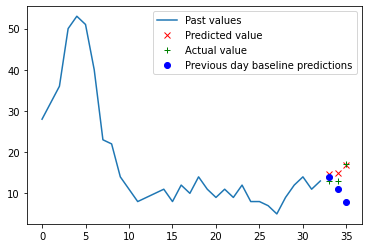

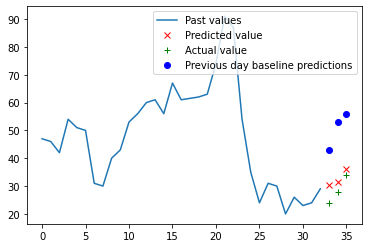

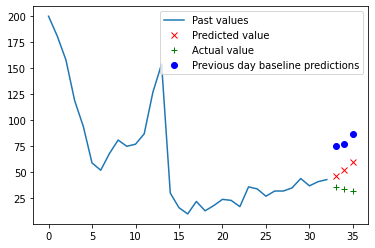

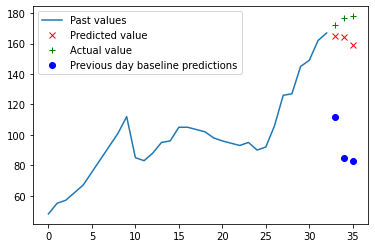

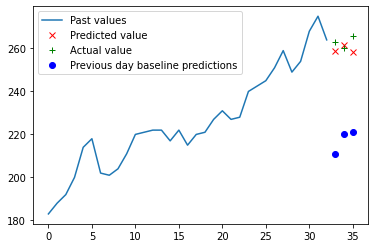

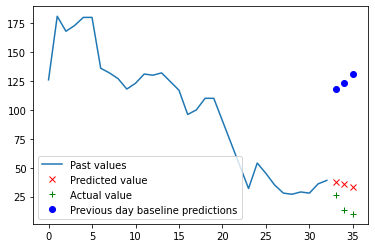

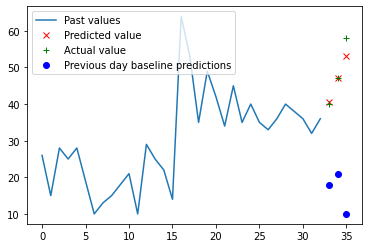

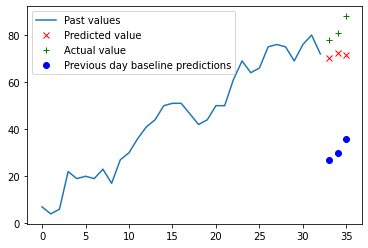

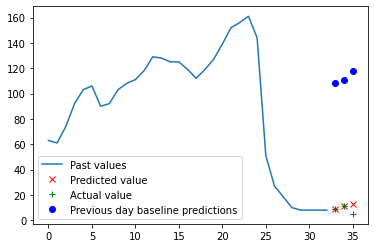

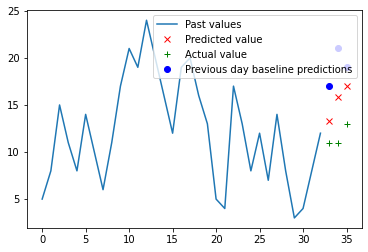

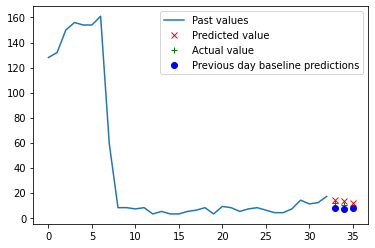

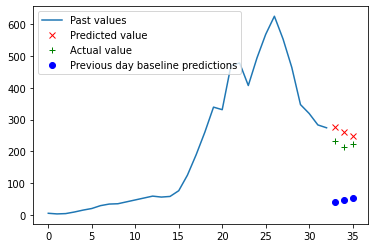

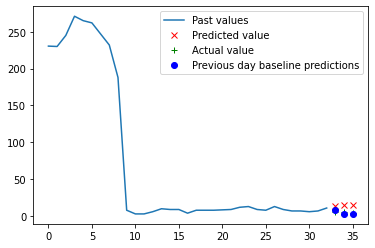

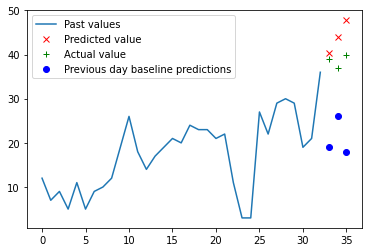

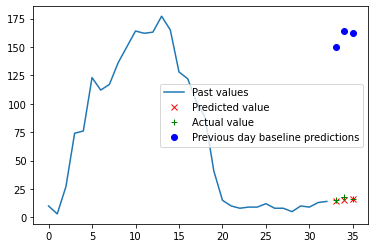

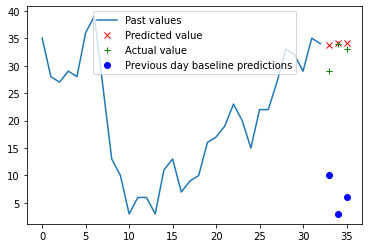

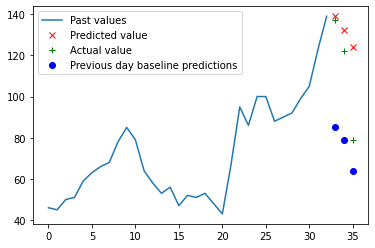

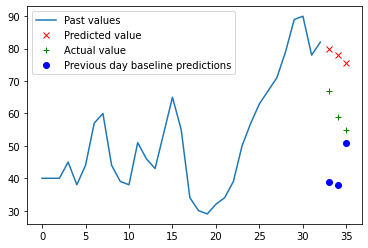

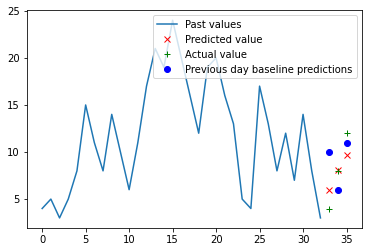

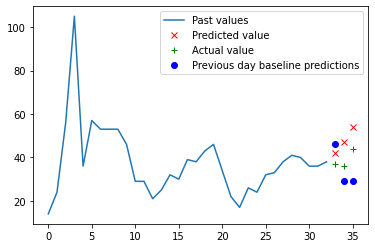

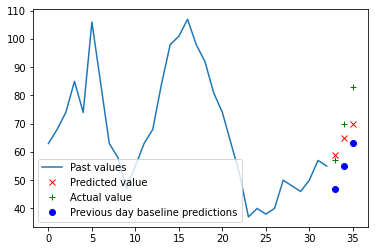

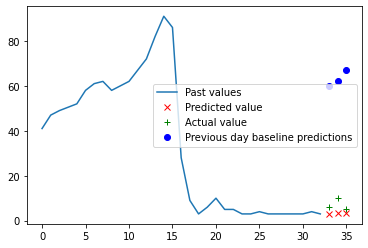

In [389]:
# during inference, one only provides past values
# as well as possible additional features
# the model autoregressively generates future values
mean_predictions = []
past_vals = []


outputs = model.generate(
    past_values=past_values,
    past_time_features=past_time_features,
    past_observed_mask=None,
    static_categorical_features=None,
    static_real_features=None,
    future_time_features=future_time_features,
)


mean_prediction = outputs.sequences.mean(dim=1)


for i in range(len(mean_prediction)):
    plt.plot(past_values[i][40:], label='Past values')
    plt.plot(range(33,36), mean_prediction[i], 'rx', label='Predicted value')
    plt.plot(range(33,36), future_values[i], 'g+', label='Actual value')
    plt.plot(range(33,36), past_values[i][-24:-21], 'bo', label='Previous day baseline predictions')
    plt.legend()
    
    plt.show()

In [379]:
# create empty arrays to store actual and predicted values
actual_values = []
predicted_values = []

# loop through validation data and generate predictions
for x, y in valloader:
    y = y.squeeze()
    past_values = x[:, :, 0]
    past_time_features = x[:, :, 1:4]
    last_time_features = x[:,-3:,1:]
    future_time_features = get_future_time_features(last_time_features)

    outputs = model.generate(
        past_values=past_values,
        past_time_features=past_time_features,
        past_observed_mask=None,
        static_categorical_features=None,
        static_real_features=None,
        future_time_features=future_time_features, 
    )

    # append actual and predicted values to corresponding arrays
    actual_values.append(y.detach().numpy())
    predicted_values.append(outputs.sequences.mean(dim=1).detach().numpy())



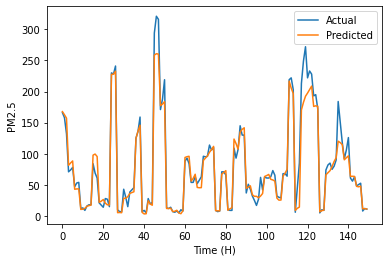

In [384]:
actual_values = np.array(actual_values).flatten()
predicted_values = np.array(predicted_values).flatten()
# plot actual and predicted values
plt.plot(actual_values[:150], label='Actual')
plt.plot(predicted_values[:150], label='Predicted')
plt.xlabel('Time (H)')
plt.ylabel('PM2.5')
plt.legend()
plt.show()